In [213]:
#library imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import talib
import warnings
warnings.filterwarnings('ignore')

In [214]:
#data imports
volumes = pd.read_csv('Data/stock_volumes.csv', index_col = 'date', parse_dates = True)
prices = pd.read_csv('Data/stock_prices.csv', index_col = 'date', parse_dates = True)
info = pd.read_csv('Data/stock_info.csv')
sp_listings = pd.read_csv('Data/sp500_listings.csv', index_col = 'date', parse_dates = True)

# Sample Stock

In [215]:
#select one stock
stock1 = prices[['905270']]
stock1.rename(columns = {'905270':'Price'}, inplace = True)

In [216]:
#find when stock was delisted
delist_date = sp_listings.where(sp_listings['stock'] == '905270').last_valid_index() + pd.DateOffset(1)

In [217]:
#set all values after delist date to NaN
stock1.loc[delist_date:]['Price'] = np.nan

In [218]:
#drop missing values
stock1.dropna(inplace = True)

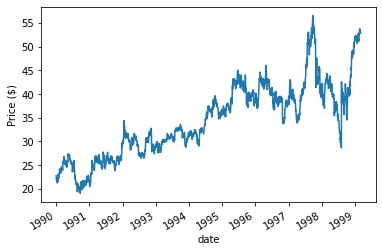

In [219]:
#EDA
stock1['Price'].plot()
plt.ylabel('Price ($)')
plt.show()

In [220]:
#Create target
stock1['10d_future_price'] = stock1['Price'].shift(-10)

In [221]:
#Create features
feature_names = []
for n in [14, 50, 200]:
    stock1['ma' + str(n)] = talib.SMA(stock1['Price'].values, timeperiod = n)/stock1['Price']
    stock1['rsi' + str(n)] = talib.RSI(stock1['Price'].values, timeperiod = n)
    feature_names += ['ma' + str(n), 'rsi' + str(n)]

In [222]:
stock1.corr()[['10d_future_price']].sort_values(by='10d_future_price', ascending = False)

,10d_future_price
10d_future_price,1.000000
Price,0.970540
rsi50,0.289926
rsi200,0.266427
rsi14,0.199373
ma14,-0.098546
ma50,-0.223523
ma200,-0.261589


In [223]:
#Drop null values
stock1.dropna(inplace = True)

In [224]:
#Create features and targets
X = stock1[feature_names]
y = stock1[['10d_future_price']]

In [225]:
#Split data into train, test
test_pct = 0.2
test_size = int(test_pct * stock1.shape[0])
X_train = X[test_size:]
y_train = y[test_size:]
X_test = X[:test_size]
y_test = y[:test_size]

## Random Forest

In [226]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [227]:
#Random Forest
rf = RandomForestRegressor(n_estimators=200)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200)

In [228]:
#Calculate R2 score
print(rf.score(X_train, y_train))
print(rf.score(X_test, y_test))

0.9804540376918145
-22.391661659160764


In [229]:
# Hyperparameter Tuning
param_dist = {'n_estimators':[100, 150, 200, 250],
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'random_state': [42]}
test_scores = []

rf_tune = RandomizedSearchCV(estimator = rf,
                             param_distributions = param_dist,
                             n_jobs = -1, scoring = 'r2')

In [230]:
rf_tune.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=200), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'n_estimators': [100, 150, 200, 250],
                                        'random_state': [42]},
                   scoring='r2')

In [231]:
rf_tune.best_params_

{'random_state': 42, 'n_estimators': 150, 'max_depth': 9}

In [232]:
rf_tune.best_score_

-6.027546357740214

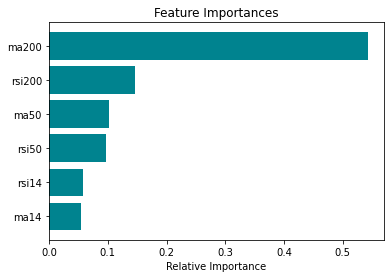

In [233]:
#Examine feature importances
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='#00838fff', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Evaluation

In [239]:
#Evaluate on train set
rf_train_pred = pd.DataFrame(rf.predict(X_train))
rf_train_pred.index = y_train.index
rf_train_eval = pd.concat([y_train, rf_train_pred], axis = 1)
rf_train_eval.columns = ['actual', 'predicted']

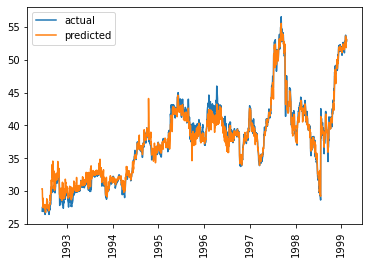

In [251]:
#Visualize
plt.plot(rf_train_eval['actual'], label = 'actual')
plt.plot(rf_train_eval['predicted'], label = 'predicted')
plt.xticks(rotation = 90)
plt.legend()

In [252]:
#Evaluate on test set
rf_test_pred = pd.DataFrame(rf.predict(X_test))
rf_test_pred.index = y_test.index
rf_test_eval = pd.concat([y_test, rf_test_pred], axis = 1)
rf_test_eval.columns = ['actual', 'predicted']

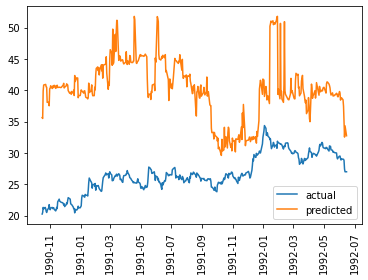

In [253]:
#Visualize
plt.plot(rf_test_eval['actual'], label = 'actual')
plt.plot(rf_test_eval['predicted'], label = 'predicted')
plt.xticks(rotation = 90)
plt.legend()

## XGBoost

In [255]:
from xgboost import XGBRegressor

In [256]:
#XGBoost Regressor
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [257]:
#Calculate R2 score
print(xgb.score(X_train, y_train))
print(xgb.score(X_test, y_test))

0.9958098860751797
-23.715074171373892


### Hyperparameter Tuning

In [259]:
xgb_tune= RandomizedSearchCV(
                estimator = xgb,
                param_distributions = param_dist, 
                scoring = 'r2', 
                n_jobs = -1)

In [260]:
xgb_tune.fit(X_train, y_train)

RandomizedSearchCV(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          gpu_id=-1, importance_type='gain',
                                          interaction_constraints='',
                                          learning_rate=0.300000012,
                                          max_delta_step=0, max_depth=6,
                                          min_child_weight=1, missing=nan,
                                          monotone_constraints='()',
                                          n_estimators=100, n_jobs=8,
                                          num_parallel_tree=1, random_state=0,
                                          reg_alpha=0, reg_lambda=1,
                                          scale_pos_weight=1, subsample=1,
  

In [261]:
xgb_tune.best_params_

{'random_state': 42, 'n_estimators': 150, 'max_depth': 4}

In [262]:
xgb_tune.best_score_

-5.543616965752608

### Evaluation

In [263]:
#Evaluate on train set
xgb_train_pred = pd.DataFrame(xgb.predict(X_train))
xgb_train_pred.index = y_train.index
xgb_train_eval = pd.concat([y_train, rf_train_pred], axis = 1)
xgb_train_eval.columns = ['actual', 'predicted']

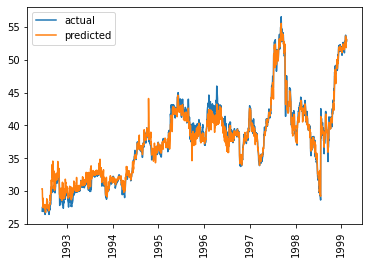

In [264]:
#Visualize
plt.plot(xgb_train_eval['actual'], label = 'actual')
plt.plot(xgb_train_eval['predicted'], label = 'predicted')
plt.xticks(rotation = 90)
plt.legend()

In [265]:
#Evaluate on test set
xgb_test_pred = pd.DataFrame(xgb.predict(X_test))
xgb_test_pred.index = y_test.index
xgb_test_eval = pd.concat([y_test, rf_test_pred], axis = 1)
xgb_test_eval.columns = ['actual', 'predicted']

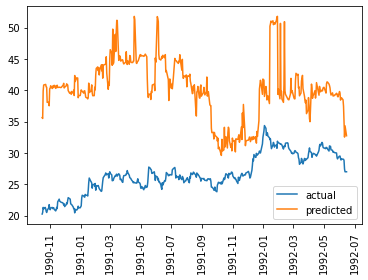

In [266]:
#Visualize
plt.plot(xgb_test_eval['actual'], label = 'actual')
plt.plot(xgb_test_eval['predicted'], label = 'predicted')
plt.xticks(rotation = 90)
plt.legend()

## Autoencoders

In [275]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import load_model

In [276]:
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)

In [277]:
# AutoEncoder Model Preparation
n_inputs = X.shape[1]
# define encoder
input_data_shape= Input(shape=(n_inputs,))
# encoder level 1
encoder= Dense(n_inputs*2)(input_data_shape)
encoder = BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# encoder level 2
encoder= Dense(n_inputs)(encoder)
encoder= BatchNormalization()(encoder)
encoder= LeakyReLU()(encoder)
# bottleneck
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(encoder)
# define decoder, level 1
decoder = Dense(n_inputs)(bottleneck)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)
# decoder level 2
decoder = Dense(n_inputs*2)(decoder)
decoder = BatchNormalization()(decoder)
decoder = LeakyReLU()(decoder)

In [292]:
# output layer
output = Dense(n_inputs, activation='linear')(decoder)
# define autoencoder model
model = Model(inputs=input_data_shape, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

In [293]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 12)                84        
_________________________________________________________________
batch_normalization (BatchNo (None, 12)                48        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 78        
_________________________________________________________________
batch_normalization_1 (Batch (None, 6)                 24        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 6)                 0   

In [294]:
history = model.fit(X_train, y_train, epochs=100, verbose=2, validation_data=(X_test,y_test))

Epoch 1/100
53/53 - 1s - loss: 1368.3517 - val_loss: 547.7084
Epoch 2/100
53/53 - 0s - loss: 1258.0620 - val_loss: 475.5917
Epoch 3/100
53/53 - 0s - loss: 1151.3037 - val_loss: 425.0445
Epoch 4/100
53/53 - 0s - loss: 1045.2251 - val_loss: 347.2524
Epoch 5/100
53/53 - 0s - loss: 939.1161 - val_loss: 225.7941
Epoch 6/100
53/53 - 0s - loss: 834.8844 - val_loss: 169.5842
Epoch 7/100
53/53 - 0s - loss: 732.9191 - val_loss: 122.6380
Epoch 8/100
53/53 - 0s - loss: 638.0292 - val_loss: 135.0921
Epoch 9/100
53/53 - 0s - loss: 547.5076 - val_loss: 89.3457
Epoch 10/100
53/53 - 0s - loss: 464.3730 - val_loss: 47.9586
Epoch 11/100
53/53 - 0s - loss: 388.2555 - val_loss: 70.4685
Epoch 12/100
53/53 - 0s - loss: 320.8882 - val_loss: 30.9772
Epoch 13/100
53/53 - 0s - loss: 261.6004 - val_loss: 34.7130
Epoch 14/100
53/53 - 0s - loss: 210.3036 - val_loss: 37.3108
Epoch 15/100
53/53 - 0s - loss: 166.8575 - val_loss: 31.3988
Epoch 16/100
53/53 - 0s - loss: 132.3686 - val_loss: 36.6057
Epoch 17/100
53/53 - 

In [296]:
# define an encoder model (without the decoder)
encoder = Model(inputs=input_data_shape, outputs=bottleneck)
# save the encoder to file
encoder.save('encoder.h5')

In [297]:
#Compressing the input data using Encoder Model and fitting it on the Logistic Regression model.
# load the model from file
encoder = load_model('encoder.h5')

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define the model
auto_rf = RandomForestRegressor()
# fit the model on the training set
auto_rf.fit(X_train_encode, y_train)

RandomForestRegressor()

In [298]:
#Evaluate on test set
auto_test_pred = pd.DataFrame(auto_rf.predict(X_test_encode))
auto_test_pred.index = y_test.index
auto_test_eval = pd.concat([y_test, auto_test_pred], axis = 1)
auto_test_eval.columns = ['actual', 'predicted']

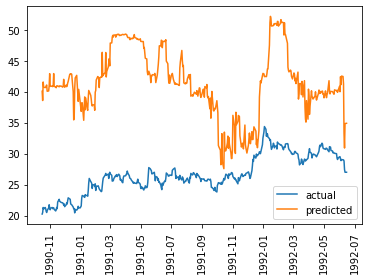

In [300]:
#Visualize
plt.plot(auto_test_eval['actual'], label = 'actual')
plt.plot(auto_test_eval['predicted'], label = 'predicted')
plt.xticks(rotation = 90)
plt.legend()